In [1]:
import pandas as pd
import numpy as np
import numpy as np
import re
import seaborn as sns
from scipy import stats
import math
import operator
import plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, plot
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import feather

In [2]:
### Cargar dataset "limpio"
df = feather.read_dataframe("Data/principal.feather")
df.sample(1)

,property_type,lat-lon,lat,lon,price,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,ambientes,provincia,partido,localidad,condicion,price_aprox_usd_levels,geonames_id
82630,1,"-34.6118003157,-58.4905672505",-34.6118,-58.490567,158000.0,158000.0,72.0,60.0,2194.444444,2633.333333,3.0,5.0,173.0,NaN,NaN,3,3427455.0


In [3]:
to_drop = [
            'price_usd_per_m2', 
            'price_per_m2', 
            'price',
#             'localidad',
            'condicion'
] 
df.drop(columns=to_drop, inplace=True) #aplicar drop
df.sample(1)

,property_type,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,provincia,partido,localidad,price_aprox_usd_levels,geonames_id
103365,2,"-36.0,-60.0",-36.0,-60.0,130000.0,1300.0,NaN,NaN,0.0,NaN,NaN,3,3435907.0


In [4]:
df.isnull().sum()

property_type                 0
lat-lon                       0
lat                        8346
lon                        8346
price_aprox_usd           23831
surface_total_in_m2        9687
surface_covered_in_m2     11755
ambientes                 30280
provincia                     0
partido                    1904
localidad                 68992
price_aprox_usd_levels    23831
geonames_id                  97
dtype: int64

In [5]:
# Creamos nueva variable de superficie por cada ambiente
# vamos probando  el efecto entre varias combinaciones
df['surface_by_amb'] = df.surface_total_in_m2/df.ambientes
df['surface_by_add'] = df.surface_total_in_m2+df.surface_covered_in_m2
df['surface_covered_prop'] = df.surface_covered_in_m2/df.surface_total_in_m2
df['surface_total_prop_cov'] = df.surface_total_in_m2/df.surface_covered_in_m2
df['surface_cov_complete'] = df.surface_covered_in_m2.fillna(df.surface_total_in_m2)
df['new_rel1'] = (df.surface_total_in_m2+df.surface_covered_in_m2)+df.ambientes
df['new_rel2'] = df.surface_cov_complete+df.surface_total_prop_cov
df['new_rel3'] = (df.surface_cov_complete+df.surface_total_prop_cov)/df.ambientes
df['new_rel4'] = (df.surface_cov_complete/df.ambientes)
df['new_rel5'] = (df.surface_cov_complete+df.surface_total_prop_cov/df.ambientes)
df['new_rel6'] = ((df.surface_cov_complete/df.ambientes)+df.surface_total_prop_cov)
df.sample(1)

,property_type,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,provincia,partido,...,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
72026,2,"-34.42058,-58.58279",-34.42058,-58.58279,140000.0,100.0,100.0,NaN,0.0,8.0,...,200.0,1.0,1.0,100.0,NaN,101.0,NaN,NaN,NaN,NaN


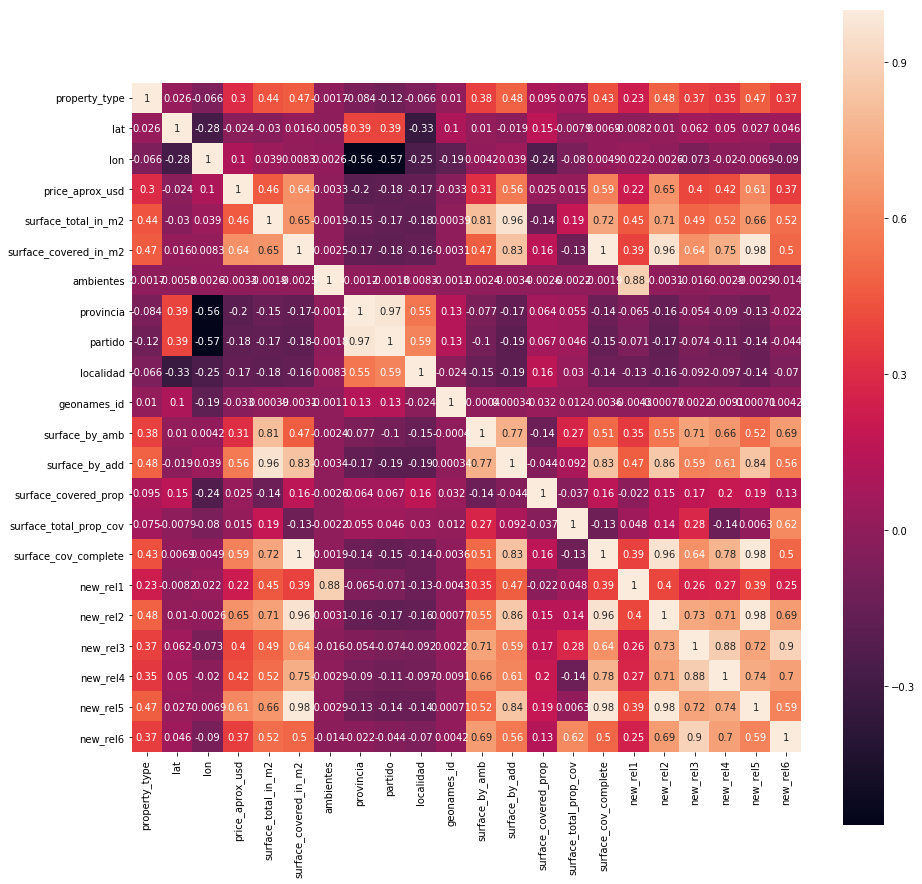

In [6]:
# Matriz de correlacion
fig, ax = plt.subplots(figsize=(15,15))       
sns.heatmap(df.corr() , square=True, annot=True, ax=ax);

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/opt/conda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1876: RuntimeWarning:

invalid value encountered in greater



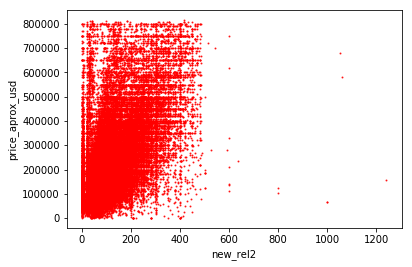

In [181]:
#reviso relación entre new_rel2 y price_aprox_usd
sns.regplot(df.new_rel2,df.price_aprox_usd, order=1, ci=None, scatter_kws={'color':'r', 's':1})
# ಠ ʖ̯ ͡ಠ

In [29]:
# Guardar data de training vs validation
X = df.drop(['price_aprox_usd'], axis = 1)
y = df['price_aprox_usd']

# Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X.sample(2)

,property_type,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,provincia,partido,...,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
3628,1,"-34.66807175,-58.57782364",-34.668072,-58.577824,NaN,1.444695,1.0,2.0,1.0,14.0,...,2.444695,0.692188,1.444695,1.0,4.444695,2.444695,1.222348,0.5,1.722348,1.944695


In [18]:
#  Rompo todas las columnas porque no puedo graficar sns.pairplot 
# ◔̯◔
to_drop = [
            'new_rel1', 
            'new_rel3', 
            'new_rel4', 
            'new_rel6', 
            'geonames_id', 
            'lat-lon',
            'surface_covered_in_m2',
            'lat','lon',
            'surface_by_amb',
            'surface_by_add',
            'surface_covered_prop',
            'surface_total_prop_cov',
            'surface_cov_complete',
            'price_aprox_usd_levels',
            'ambientes',
#             'property_type',
] 
df.drop(columns=to_drop, inplace=True) #aplicar drop
df.sample(1)

,property_type,price_aprox_usd,surface_total_in_m2,provincia,partido,localidad,new_rel2,new_rel5
16777,2,165000.0,140.0,10.0,300.0,NaN,141.0,140.5


In [19]:
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["new_rel2","new_rel5"], how="all")
df.describe()

,property_type,price_aprox_usd,surface_total_in_m2,provincia,partido,localidad,new_rel2,new_rel5
count,105449.000000,87551.000000,105449.000000,105449.000000,104145.000000,45652.000000,105449.000000,85076.000000
mean,1.316466,192571.925405,144.785233,5.440298,128.490873,282.942894,101.652639,95.408105
std,0.604668,146273.535667,184.320307,6.712574,145.652471,121.524086,90.005078,86.410899
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-3.555556
25%,1.000000,90000.000000,45.000000,1.000000,14.000000,220.000000,42.219512,40.500000
50%,1.000000,140000.000000,76.000000,4.000000,67.000000,257.000000,68.089552,65.333333
75%,2.000000,250000.000000,175.821128,5.000000,168.000000,395.000000,133.363636,124.422754
max,3.000000,815000.000000,1490.000000,27.000000,538.000000,567.000000,1362.000000,1362.000000


In [20]:
#  Rompo todas las columnas 
# 
columnas_principales = ['price_aprox_usd','surface_total_in_m2','partido','new_rel2','new_rel5']
df = df.dropna(axis =0 , how = 'any', subset = columnas_principales)
df.shape

(70819, 8)

In [21]:
# elimino columna localidad porque no la voy a utilizar
df.drop(columns=['localidad'], inplace=True) #aplicar drop
# elimino todos los que tengan nulos dado los fill infinites de new_rel2 y new_rel5
df = df.dropna(axis=0 , how = 'any')
df.shape
df.sample(1)

,property_type,price_aprox_usd,surface_total_in_m2,provincia,partido,new_rel2,new_rel5
74260,1,89000.0,52.0,2.0,28.0,53.0,27.0


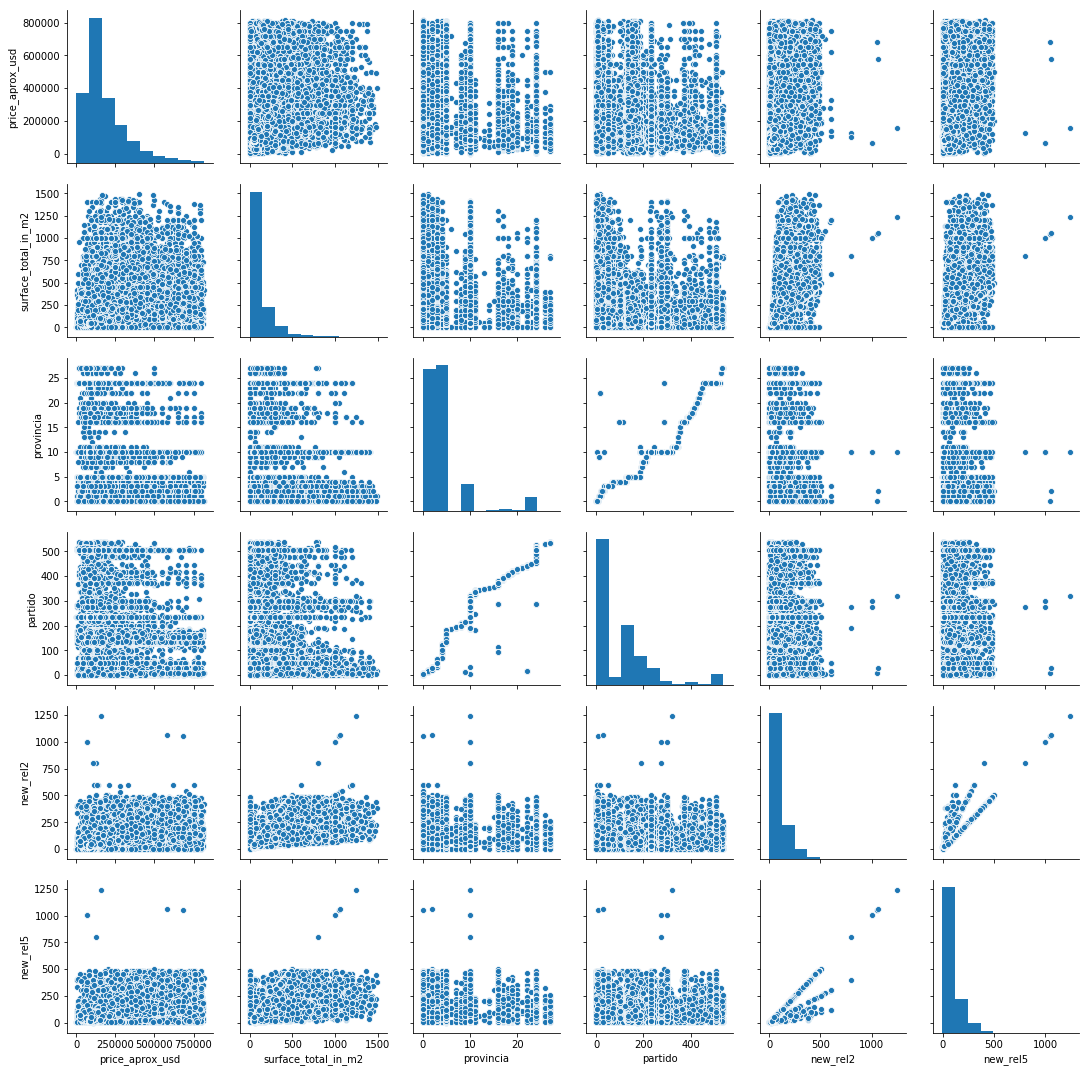

In [12]:
sns.pairplot(df)

In [22]:
# Agrupamos los datos por provincia
###Crear dummies para las siguientes categoricas
#### *provincia
#### *partido
#### *localidad --> eliminada

#Provincia
# df = pd.concat([df, pd.get_dummies(data = df['provincia'], prefix= 'dum_prov')], axis = 1)
#Localidad
df = pd.concat([df, pd.get_dummies(data = df['partido'], prefix= 'dum_part')], axis = 1)
df = pd.concat([df, pd.get_dummies(data = df['property_type'], prefix= 'dum_tprop')], axis = 1)


In [23]:
#  Dropear columnas pasadas a dummies 
to_drop = [
            'provincia', 
            'partido', 
            'property_type',
] 
df.drop(columns=to_drop, inplace=True) #aplicar drop
df.sample(1)

,price_aprox_usd,surface_total_in_m2,new_rel2,new_rel5,dum_part_0.0,dum_part_1.0,dum_part_2.0,dum_part_3.0,dum_part_4.0,dum_part_5.0,...,dum_part_528.0,dum_part_529.0,dum_part_534.0,dum_part_535.0,dum_part_536.0,dum_part_538.0,dum_tprop_0,dum_tprop_1,dum_tprop_2,dum_tprop_3
37674,49500.0,34.0,35.0,34.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [27]:
X = df.drop(['price_aprox_usd','surface_total_in_m2','new_rel5',
            'dum_tprop_0','dum_tprop_1','dum_tprop_2','dum_tprop_3'], axis = 1)
y = df['price_aprox_usd']

# Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X.sample(2)

,new_rel2,dum_part_0.0,dum_part_1.0,dum_part_2.0,dum_part_3.0,dum_part_4.0,dum_part_5.0,dum_part_6.0,dum_part_7.0,dum_part_8.0,...,dum_part_517.0,dum_part_520.0,dum_part_523.0,dum_part_525.0,dum_part_528.0,dum_part_529.0,dum_part_534.0,dum_part_535.0,dum_part_536.0,dum_part_538.0
97485,46.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97903,59.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Regresion linear
lm = LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_train)
model_score = model.score(X_test, y_test)
print('Model Score: ',model_score)
#el score mejora al utilizar localidad vs provincia
# print ('Intercepto=', ' ', model.intercept_)
# print ('RM=', ' ', model.coef_)

Model Score:  0.5332065762403329


ValueError: x and y must be the same size

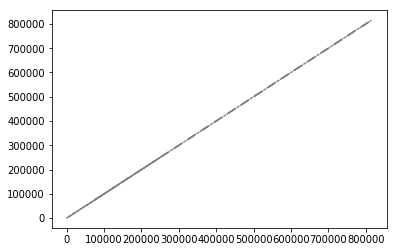

In [296]:
# Graficamos la variable X contra la variable Y
# plt.scatter([X_train], [y_train], s=30, c='r', marker='+', zorder=10)
# plt.xlabel("RM")
# plt.ylabel("Valores reales MEDV")
# plt.show()

# Graficamos el modelo
plt.plot(y_train,y_train, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de MEDV usando RM")
plt.ylabel("Valores reales MEDV")
plt.show()